In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [22]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [30]:
#binary classification task
#predict correct class labels
#minimax on f (classifier)
#implementation details from https://arxiv.org/pdf/1710.10571 and https://arxiv.org/pdf/1906.00331

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import csv

eta_x = 5e-5  #theta lr
eta_y = 1e-4 #x_adv lr
inner_steps = 1  #1 for gda, 20 for gdmax
gamma = 1.3 #adversarial perturbation {0.4, 1.3}

class Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__() #input (batch_size, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=8) #3 conv layers, mnist grayscale, (batch_size, 32, 21, 21)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6) #(batch_size, 64, 16, 16)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5) #(batch_size, 128, 12, 12)
        self.fc = nn.Linear(128*12*12, num_classes) 

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.flatten(start_dim=1)
        return self.fc(x)

#wasserstein robust loss
def wrm_loss(model, x, y, gamma, inner_steps):
    x_adv = x.clone() #x_adv = alpha in orig paper -> inner max var
    x_adv = x_adv.detach().requires_grad_(True)
    for step in range(inner_steps):
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y, reduction='none')#cross entropy loss, l(f(x'),y)
        penalty = gamma*((x_adv-x)**2).flatten(start_dim=1).sum(dim=1) #gamma||x'-x||^2
        total = (loss-penalty).sum()
        grad = torch.autograd.grad(total, x_adv, create_graph=True)[0]
        x_adv = x_adv+eta_y*grad
    logits = model(x_adv)
    return F.cross_entropy(logits, y) #min loss wrt theta



In [32]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x) #forwards pass outputs
            preds = logits.argmax(dim=1) #predict class -> max logit value
            correct += (preds == y).sum().item() #num correct preds
            total += y.size(0) #total num preds
    model.train()
    return correct/total #accuracy

def run_training(inner_steps, mode):
    theta = Classifier().to(device)
    opt_theta = optim.SGD(theta.parameters(), lr=eta_x) #learning rate optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(opt_theta, step_size=10, gamma=0.5) #reduce learning rate every 10 steps
    csv_file = f"{mode}.csv"
    with open(csv_file, mode="w", newline="") as log_file:
        writer = csv.writer(log_file)
        writer.writerow(["Epoch", "Loss", "Test Accuracy", "Gradient Calls"])
        total_grad_calls = 0
        if mode == "GDA":
            epochs = 10
        else:
            epochs = 5 #gdmax too slow
        max_batches = 200 
        for epoch in range(epochs):
            for i, (x, y) in enumerate(train_loader):
                if i >= max_batches:
                    break
                x, y = x.to(device), y.to(device)
                loss = wrm_loss(theta, x, y, gamma=gamma, inner_steps=inner_steps)
                opt_theta.zero_grad()
                loss.backward() #downhill gradient
                opt_theta.step() #theta update step
                total_grad_calls += inner_steps+1

            acc = evaluate(theta, test_loader)
            print(f"{mode} -> Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}, Grad Calls: {total_grad_calls}")
            writer.writerow([epoch + 1, loss.item(), acc, total_grad_calls])
            scheduler.step()

for mode in ["GDA", "GDmax"]:
    if mode == "GDA":
        inner_steps = 1
    else:
        inner_steps = 20
    run_training(inner_steps, mode)

#note: GDmax runs much slow (20min) than GDA (2min), which makes sense


GDA -> Epoch 1, Loss: 2.2961, Test Acc: 0.1289, Grad Calls: 400
GDA -> Epoch 2, Loss: 2.2718, Test Acc: 0.1732, Grad Calls: 800
GDA -> Epoch 3, Loss: 2.2583, Test Acc: 0.2082, Grad Calls: 1200
GDA -> Epoch 4, Loss: 2.2345, Test Acc: 0.2620, Grad Calls: 1600
GDA -> Epoch 5, Loss: 2.2443, Test Acc: 0.3086, Grad Calls: 2000
GDA -> Epoch 6, Loss: 2.2080, Test Acc: 0.3346, Grad Calls: 2400
GDA -> Epoch 7, Loss: 2.1857, Test Acc: 0.3555, Grad Calls: 2800
GDA -> Epoch 8, Loss: 2.1601, Test Acc: 0.3789, Grad Calls: 3200
GDA -> Epoch 9, Loss: 2.1514, Test Acc: 0.3995, Grad Calls: 3600
GDA -> Epoch 10, Loss: 2.1490, Test Acc: 0.4242, Grad Calls: 4000
GDmax -> Epoch 1, Loss: 2.2687, Test Acc: 0.1423, Grad Calls: 4200
GDmax -> Epoch 2, Loss: 2.2573, Test Acc: 0.2242, Grad Calls: 8400
GDmax -> Epoch 3, Loss: 2.2393, Test Acc: 0.3079, Grad Calls: 12600
GDmax -> Epoch 4, Loss: 2.2220, Test Acc: 0.3490, Grad Calls: 16800
GDmax -> Epoch 5, Loss: 2.1933, Test Acc: 0.3435, Grad Calls: 21000


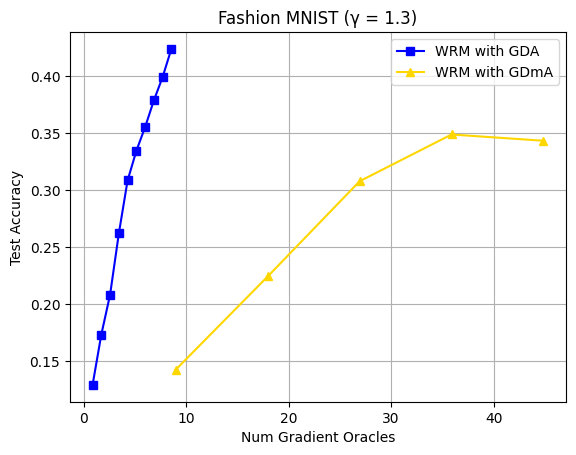

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

gda = pd.read_csv("GDA.csv")
gdmax = pd.read_csv("GDmax.csv")
batch_size = 128
batches_per_epoch = 60000//batch_size
gda["Oracle Calls"] = gda["Gradient Calls"]/batches_per_epoch #scaling used in paper
gdmax["Oracle Calls"] = gdmax["Gradient Calls"]/batches_per_epoch

plt.figure()
plt.plot(gda["Oracle Calls"], gda["Test Accuracy"], label="WRM with GDA", marker='s', color='blue')
plt.plot(gdmax["Oracle Calls"], gdmax["Test Accuracy"], label="WRM with GDmA", marker='^', color='gold')
plt.xlabel("Num Gradient Oracles")
plt.ylabel("Test Accuracy")
plt.title("Fashion MNIST (γ = 1.3)")
plt.grid(True)
plt.legend()
plt.show()

#plot differences - doing only 5 epochs but paper does until convergence
#try to run more epoch of gda to get to converge
